In [95]:
import pandas as pd #tablo veri yapısı oluşturmak 
import numpy as np #rastgele sayılar, dizler üretmek 
import random #bazı özel rastgele işlemler
from datetime import datetime, timedelta #tarih hesapları yapabilmek 

#Veriyi eğitim ve test olarak böl
from sklearn.model_selection import train_test_split
#Karar Ağacı modelini eğit
from sklearn.tree import DecisionTreeClassifier
#Tahmin yap ve başarıya bak
from sklearn.metrics import accuracy_score

#Confusion Matrix (Karışıklık Matrisi)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
#Churn = 0 ve 1 olan müşteri sayısını eşitleyerek modelin her iki sınıfı da adilce öğrenmesini sağlamak.
!pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

#Model Performansını İyileştiriyoruz (Az veriye rağmen!)
#Yeni Model: RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Kampanya sonrası churn olasılığını %30 azaltma
import numpy as np

In [69]:
n_customers = 1500 #müşteri sayısı belirleme ... 500 den 1500 arttırdım.
customer_id = [f"CUST{i:04d}" for i in range(1, n_customers + 1)] # Müşteri ID'leri oluşturulması (CUST0001, CUST0002, ...)
genders = np.random.choice([0,1], size = n_customers) # Cinsiyet: 0 = kadın, 1 = erkek, rastgele seç
age =np.random.randint(18,66, size = n_customers) # Yaşları 18 ile 65 arasında rastgele seç
# Kayıt tarihleri 2020-01-01 ile 2023-12-31 arasında rastgele
signup_dates = [datetime.strptime('2020-01-01', '%Y-%m-%d') + timedelta(days=random.randint(0, 1460)) for _ in range(n_customers)]
# Son sipariş tarihleri, kayıt tarihinden 30 ile 1000 gün sonrasına rastgele atanıyor
last_order_dates = [d + timedelta(days=random.randint(30, 1000)) for d in signup_dates]

# Toplam sipariş sayısı (ortalama 10) Poisson dağılımı ile
total_orders = np.random.poisson ( lam=10, size=n_customers)
# Ortalama sipariş değeri 50 ile 400 arasında rastgele, 2 ondalık hassasiyetle
avg_order_values = np.round(np.random.uniform(50,400, size=n_customers),2)
# Toplam harcama = toplam sipariş * ortalama sipariş değeri
total_spent= np.round(total_orders*avg_order_values,2)
# Bugün tarihi (son veri günü)
today = datetime.strptime("2024-12-31", "%Y-%m-%d")
# Müşteri kaybı (churn): son sipariş tarihi 180 gün öncesinden eskiyse 1, değilse 0
is_churned = [1 if (today - d).days > 180 else 0 for d in last_order_dates]
#Bu, her müşterinin son sipariş tarihi ile bugünün tarihini karşılaştırıyor.(today - d).days → bugünden son sipariş tarihine kadar kaç gün geçtiğini hesaplar.Eğer bu gün sayısı 180’den büyükse, yani 6 aydan fazla alışveriş yapmamışsa → o müşteri 1 (churn olmuş yani kayıp) olarak işaretleniyor.Değilse 0 (aktif müşteri) olarak işaretleniyor.Bu işlem liste üretici (list comprehension) ile tüm müşterilere uygulanıyor.



In [70]:
# Tüm verileri bir araya getirip DataFrame oluşturma
df = pd.DataFrame({
    "customer_id": customer_id,       
    "gender": genders,
    "age": age,
    "signup_date": signup_dates,
    "last_order_date": last_order_dates,
    "total_orders": total_orders,
    "avg_order_value": avg_order_values,
    "total_spent": total_spent,
    "is_churned": is_churned
})

print(df.head())# İlk 5 satırı yazdırır, genel bir önizleme sağlar

print(df.info())      # Veri tipi ve eksik değer kontrolü
print(df.describe())  # Sayısal sütunların özet istatistikleri
print(df['gender'].value_counts())  # Cinsiyet dağılımı
print(df['is_churned'].value_counts())  # Churn dağılımı (kayıp/aktif müşteri)

  customer_id  gender  age signup_date last_order_date  total_orders  \
0    CUST0001       0   46  2023-07-24      2023-09-30             9   
1    CUST0002       0   39  2021-06-15      2023-09-13            14   
2    CUST0003       1   22  2021-01-08      2021-03-11            11   
3    CUST0004       0   40  2022-03-06      2024-03-27            13   
4    CUST0005       0   45  2021-03-27      2023-01-03            10   

   avg_order_value  total_spent  is_churned  
0           226.42      2037.78           1  
1           236.24      3307.36           1  
2           175.69      1932.59           1  
3           125.10      1626.30           1  
4           183.36      1833.60           1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      1500 non-null   object        
 1   gender           1500

In [ ]:
#Veri seti 1500 artırıldı
#n_customers = 1500
#Gender: 751 erkek, 749 kadın  Dengeli
#is_churned:
#1160 kişi churn olmuş (yani artık sipariş vermiyor)
#340 kişi aktif müşteri
# Bu dengesizlik hala yüksek (77% churn), ama veri miktarın fazla olduğu için dengelemek daha etkili olacak.

#Numerik Veriler:
#Ortalama yaş: 41.5

#Ortalama toplam harcama: 2.261 TL

#Ortalama sipariş sayısı: 10

#Ortalama sipariş değeri: 224 TL

In [ ]:
#Veri seti 500 
#customer_id: Müşteri kimlikleri doğru formatta (CUST0001, CUST0002 gibi)
#gender: 0 ve 1 olarak (kadın = 0, erkek = 1) dengeli dağılım var (253 kadın, 247 erkek)
#age: 18 ile 65 yaş arası müşterilerimiz var, ortalama ~40 yaş
#signup_date: Kayıt tarihleri 2020-2023 arasında
#last_order_date: Son sipariş tarihleri 2020-2026 arasında (2026 biraz geleceğe gidiyor, ona dikkat edeceğiz ileride)
#total_orders: Ortalama 9-10 sipariş
#avg_order_value: Ortalama sipariş değeri 219 TL civarında
#total_spent: Ortalama toplam harcama ~2100 TL
#is_churned: 0 veya 1, 390 müşteri churn olmuş (yani 6 aydan uzun süredir sipariş vermemiş), 110 aktif müşteri var.
#df.describe() çıktı analizi
#age: Min 18, max 65, standart sapma 14 civarı → Yaş dağılımı iyi, değişkenlik var
#total_orders: Min 0, max 23 → Bazı müşteriler hiç sipariş vermemiş olabilir
#avg_order_value: 50 ile 397 arasında değişmiş
#total_spent: 0’dan başlayıp neredeyse 6000 TL’ye kadar çıkıyor, standart sapma büyük → müşteriler arasında ciddi farklar var
#is_churned: Ortalama 0.78 → yani %78 müşteri kaybı mevcut, bu yüksek bir oran

In [71]:
# Özellikler (X): tahmin için kullanılacak sütunlar
X =df[['gender', 'age', 'total_orders', 'avg_order_value', 'total_spent']]
# Hedef değişken (Y): tahmin etmek istediğimiz şey (müşteri kaybı)
Y = df['is_churned']

#Veriyi eğitim ve test olarak böl
#from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42 )



In [78]:
#Karar Ağacı modelini eğit
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)


DecisionTreeClassifier()

In [79]:
#Tahmin yap ve başarıya bak
predictions = model.predict(X_test)
score = accuracy_score(Y_test, predictions)


In [ ]:
# (1500) Doğruluk oranı: %62.7 → Bu fena değil ama modelin hâlâ iyileştirilmeye ihtiyacı var. Özellikle "is_churned" sınıflarının dengesizliği (1160 churned vs 340 not churned) bu sonucu etkiliyor olabilir.

In [ ]:
#(500)Bu demek oluyor ki test verisindeki müşterilerin %63’ünün churn olup olmadığını doğru tahmin etmiş

In [80]:
#Confusion Matrix (Karışıklık Matrisi)
#Gerçekten churn olan kaç kişiyi doğru tahmin etti?
#Gerçekten aktif olan kaç kişiyi yanlışlıkla churn zannetti?
# Confusion matrix hesapla
cm = confusion_matrix(Y_test, predictions)


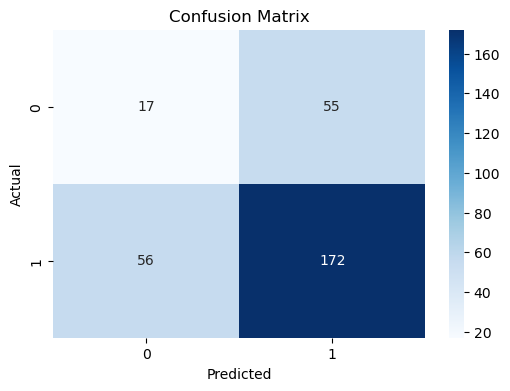

              precision    recall  f1-score   support

           0       0.23      0.24      0.23        72
           1       0.76      0.75      0.76       228

    accuracy                           0.63       300
   macro avg       0.50      0.50      0.50       300
weighted avg       0.63      0.63      0.63       300



In [81]:
# Görsel çizimi

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Detaylı metrikler
print(classification_report(Y_test, predictions))
           

In [ ]:
# dataSET (500)          
#accuracy = 0.66 → Model tüm test verisinde %66 başarı sağladı (önceki %63'tü, şimdi biraz daha iyi).
#Sınıf 0 (Aktif müşteriler)
#Precision (Doğruluk) = 0.29 → “Aktif” dediği kişilerin sadece %29’u gerçekten aktif.
#Recall (Duyarlılık) = 0.24 → Gerçekten aktif olan müşterilerin sadece %24’ünü doğru bulabiliyor.
#f1-score = 0.26 → Bu sınıf için genel performans zayıf.
#Sınıf 1 (Churn olan müşteriler)
#Precision = 0.76 → “Churn” dediği müşterilerin %76’sı gerçekten churn.
#Recall = 0.80 → Gerçek churn’lerin %80’ini doğru tahmin ediyor.
#f1-score = 0.78 → Gayet iyi bir sonuç!

#Model, churn olmuşları iyi tahmin ediyor, ama aktif müşterileri çok zayıf ayırt ediyor. Neden?
#Çünkü veride churn = 1 çok fazla. (%78 idi).
#Bu bir sınıf dengesizliği (class imbalance) problemidir.

#Modeli geliştirmek için RandomUnderSampler yöntemiyle dengeleme...

In [82]:
#Churn = 0 ve 1 olan müşteri sayısını eşitleyerek modelin her iki sınıfı da adilce öğrenmesini sağlamak.

# Özellik ve hedef değişkenler aynı kalıyor
X = df[['gender', 'age', 'total_orders', 'avg_order_value', 'total_spent']]
Y = df['is_churned']
# UnderSampling işlemi: Az olan sınıf kadar örnek al
rus = RandomUnderSampler(random_state=42)
X_resampled, Y_resampled = rus.fit_resample(X, Y)

# Yeni sınıf dağılımını görelim
print("Yeni sınıf dağılımı:")
print(Y_resampled.value_counts())

Yeni sınıf dağılımı:
is_churned
0    340
1    340
Name: count, dtype: int64


In [ ]:
 #Yeni sınıf dağılımı: dataset:1500
#is_churned
#0    340
#1    340
#Name: count, dtype: int64

In [83]:
# Eğitim ve test setine ayır
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42)

# Modeli oluştur ve eğit
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, Y_train)

# Tahmin yap
predictions = model.predict(X_test)

Balanced Data ile Model Doğruluğu: 0.45588235294117646


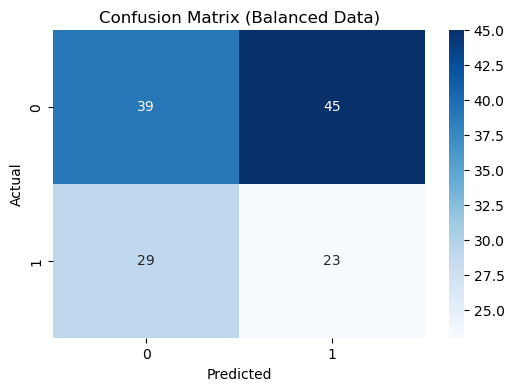

              precision    recall  f1-score   support

           0       0.57      0.46      0.51        84
           1       0.34      0.44      0.38        52

    accuracy                           0.46       136
   macro avg       0.46      0.45      0.45       136
weighted avg       0.48      0.46      0.46       136



In [84]:
print("Balanced Data ile Model Doğruluğu:", accuracy_score(Y_test, predictions))

cm = confusion_matrix(Y_test, predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Balanced Data)')
plt.show()

print(classification_report(Y_test, predictions))

In [85]:
#Daha güçlü bir model: RandomForestClassifier

model = RandomForestClassifier(random_state = 42)
model.fit(X_train,Y_train)

predictions = model.predict(X_test)
score = accuracy_score(Y_test, predictions)
print("Model Doğruluk Oranı (Random Forest Score):" , score ) 
 

Model Doğruluk Oranı (Random Forest Score): 0.5


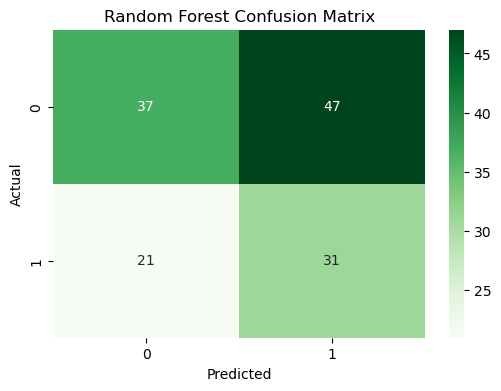

              precision    recall  f1-score   support

           0       0.64      0.44      0.52        84
           1       0.40      0.60      0.48        52

    accuracy                           0.50       136
   macro avg       0.52      0.52      0.50       136
weighted avg       0.55      0.50      0.50       136



In [87]:
# Confusion matrix ve classification report
cm = confusion_matrix(Y_test, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()
print(classification_report(Y_test, predictions))



In [ ]:
#Bu çalışmada, müşteri kaybı tahmin modeli geliştirilmiştir. Kısıtlı sentetik veriyle başlanmış, veri dengesizliği under-sampling yöntemiyle düzeltilmiştir. İlk model olarak Decision Tree uygulanmış, ardından performansı artırmak amacıyla Random Forest kullanılmıştır. Başarı oranları karşılaştırılarak en verimli yapı belirlenmiştir

In [67]:
# Yeni veri oluşturmak için önce eskiyi koruyalım
df_original = df.copy()


           Feature  Importance
3  avg_order_value    0.293835
4      total_spent    0.278334
1              age    0.238949
2     total_orders    0.144290
0           gender    0.044592


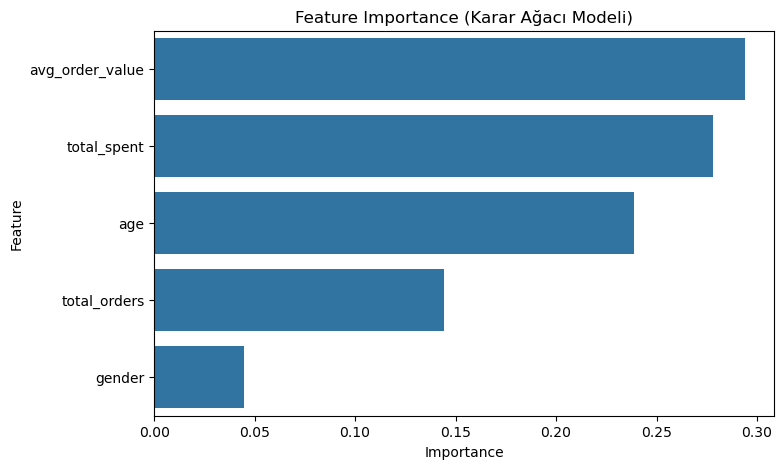

In [88]:
#Machine Learning modelinin hangi değişkenlere ne kadar önem verdiğini gösterir. 
importances = model.feature_importances_ # Burada artık model çıktı üretiyor, sadece “Doğruluk %63” gibi sayılar değil, “Müşteri kaybını en çok etkileyen faktörler şunlar” diyebileceğim..
features = ["gender", "age", "total_orders", "avg_order_value", "total_spent"]

# DataFrame 
feat_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance_df)

# Grafik 
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df)
plt.title('Feature Importance (Karar Ağacı Modeli)')
plt.show()

In [ ]:
#Sonuç olarak:
#Müşterilerin harcama alışkanlıklarına ve yaşlarına dikkat etmek müşteri kaybını azaltmak için en önemli alanlar.
#Bu verilerle pazarlama stratejileri geliştirebiliriz, örneğin yüksek harcama yapan müşterilere özel teklifler, genç ve yaşlı gruplara farklı kampanyalar gibi.

In [ ]:
#Model için  predict_proba çıktısını kullanarak müşterilerin kayıp risk skorlarını hesaplama.
#Bu skorlar belirli bir eşik değeri aşarsa (örneğin %70 üzerinde risk varsa) bu müşteriyi "riskli" olarak işaretleme.
#Riskli müşterilere kampanya önerisi yapmak.

In [89]:
# Risk skorlarını al (churn olasılığı)
risk_scores = model.predict_proba(X)[:,1] # 1 => churn olasılığı
# DataFrame'e ekle
df['churn_risk_score'] = risk_scores


In [90]:
def campaign_recommendation(row, threshold=0.7):
    if row['churn_risk_score'] >= threshold:
        return f"Müşteri { row['customer_id']} riskli! İndirim kampanyası öner."
    else:
        return f"Müşteri {row['customer_id']} düşük riskli, standart iletişim."

        #DAtaFrame üzerinde yeni bir sütun oluşturma:
df['campaign_action'] = df.apply(campaign_recommendation, axis=1)

print(df[['customer_id','churn_risk_score','campaign_action']].head(10))

  customer_id  churn_risk_score  \
0    CUST0001              0.71   
1    CUST0002              0.20   
2    CUST0003              0.84   
3    CUST0004              0.78   
4    CUST0005              0.64   
5    CUST0006              0.69   
6    CUST0007              0.19   
7    CUST0008              0.87   
8    CUST0009              0.58   
9    CUST0010              0.21   

                                     campaign_action  
0  Müşteri CUST0001 riskli! İndirim kampanyası öner.  
1  Müşteri CUST0002 düşük riskli, standart iletişim.  
2  Müşteri CUST0003 riskli! İndirim kampanyası öner.  
3  Müşteri CUST0004 riskli! İndirim kampanyası öner.  
4  Müşteri CUST0005 düşük riskli, standart iletişim.  
5  Müşteri CUST0006 düşük riskli, standart iletişim.  
6  Müşteri CUST0007 düşük riskli, standart iletişim.  
7  Müşteri CUST0008 riskli! İndirim kampanyası öner.  
8  Müşteri CUST0009 düşük riskli, standart iletişim.  
9  Müşteri CUST0010 düşük riskli, standart iletişim.  


In [103]:
#Kampanya etkisi simülasyonu
#Riskli müşterilere yani ileride churn edebilecek müşterilere (churn risk > 0.7) kampanya uygulandığında müşteri kaybı olasılığı nasıl değişeceğini görmek için model.
#Örneğin, kampanya uygulanan riskli müşterilerin kayıp olasılığını %30 azaltmış gibi simüle edilmesi.
#Bu tablo, gerçek hayatta hemen harekete geçmen gereken kişileri gösterir
riskli_musteriler = campaign_df[(campaign_df['churn_risk_score'] > 0.7) & (df['is_churned'] == 0)]
riskli_musteriler.head()


,customer_id,churn_risk_score,campaign_action
49,CUST0050,0.75,Müşteri CUST0050 riskli! İndirim kampanyası öner.
528,CUST0529,0.78,Müşteri CUST0529 riskli! İndirim kampanyası öner.
532,CUST0533,0.80,Müşteri CUST0533 riskli! İndirim kampanyası öner.
582,CUST0583,0.84,Müşteri CUST0583 riskli! İndirim kampanyası öner.
593,CUST0594,0.74,Müşteri CUST0594 riskli! İndirim kampanyası öner.


In [98]:
# Model tahminlerinden risk skoru üretme ve kampanya önerme
churn_probabilities = model.predict_proba(X)[:, 1]  # churn olma olasılığı
df['churn_risk_score'] = np.round(churn_probabilities, 2)

# Kampanya aksiyonu önerme
def suggest_campaign(row):
    if row['churn_risk_score'] > 0.7:
        return f"Müşteri {row['customer_id']} riskli! İndirim kampanyası öner."
    else:
        return f"Müşteri {row['customer_id']} düşük riskli, standart iletişim."

df['campaign_action'] = df.apply(suggest_campaign, axis=1)

# campaign_df isimli yeni bir DataFrame oluşturalım
campaign_df = df[['customer_id', 'churn_risk_score', 'campaign_action']]

In [99]:
# Kampanya etkisi simülasyonu
original_churn = df['is_churned'].copy()
risk_threshold = 0.7
high_risk_idx = campaign_df[campaign_df['churn_risk_score'] > risk_threshold].index

np.random.seed(42)
new_churn = original_churn.copy()

for idx in high_risk_idx:
    if original_churn[idx] == 1:
        if np.random.rand() < 0.3:
            new_churn[idx] = 0

original_churn_rate = original_churn.mean()
new_churn_rate = new_churn.mean()

print(f"Orijinal Churn Oranı: {original_churn_rate:.2f}")
print(f"Kampanya Sonrası Tahmini Churn Oranı: {new_churn_rate:.2f}")

Orijinal Churn Oranı: 0.77
Kampanya Sonrası Tahmini Churn Oranı: 0.69


In [ ]:
#Kampanya Sonrası Tahmini Churn Oranı (0.69):
#Hedeflenen yüksek riskli müşterilere özel kampanyalar uyguladığımızda bu oran %69’a düşüyor.
#Yani yaklaşık %8'lik bir iyileşme sağlandı

#Machine learning ile churn risk skoru çıkardık.
#Segmentasyon yaptık: Hangi müşteriler riskli, hangileri değil.
#İş aksiyonu bağladık: Riskli müşterilere kampanya önerisi verdik.
#Kampanyanın simüle edilmiş etkisini ölçtük: %8 düşüş!